# 伸び率の多いジャンル選定

In [1]:
import pandas as pd
import numpy as np
import pickle
import json
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.dates as mdates
import matplotlib.colorbar as mcolorbar
from matplotlib import colormaps
from matplotlib.colors import ListedColormap
from matplotlib.colors import hsv_to_rgb
import seaborn as sns
import itertools
from itertools import combinations
from tqdm import tqdm

import networkx as nx
import igraph as ig
import leidenalg

from collections import defaultdict
from collections import Counter

# 累積グラフ

In [2]:
import pickle
with open(r'./pickle_data/cumulative_user_listening_fin.pkl', 'rb') as f:
    df_cumulative = pickle.load(f)
print(df_cumulative.shape)
df_cumulative.head()

(28017, 4)


,top_tag,year,cumulative_unique_users,cumulative_listening_count
0,21st_century_classical,2008,1,1
1,21st_century_classical,2009,15,41
2,21st_century_classical,2010,32,113
3,21st_century_classical,2011,53,179
4,21st_century_classical,2012,148,505


#### 2005年に閾値超えていてもOK ver.

In [3]:
import pandas as pd

# ---- ここでは df_cumulative が既に以下のような列を持つDataFrameだと想定 ----
#    top_tag | year | cumulative_unique_users | cumulative_listening_count


# 1) top_tag ごとに誕生年(= 累積ユーザー数が50人超えた最初の年)を求める関数
def get_birth_year(sub_df, th_user):
    """
    sub_df: ある top_tag のみを抽出した df_cumulative
    戻り値: (birth_year, birth_count)
        birth_year: 誕生年（最初に累積ユーザー数が 50 を超えた年）
        birth_count: 上記 birth_year の累積リスニング回数(Nに相当)
                     存在しない場合は None を返す
    """
    # year の昇順にソート
    sub_df = sub_df.sort_values('year')
    
    # 累積ユーザー数が 50 を超える年を探す
    condition = sub_df['cumulative_unique_users'] >= th_user
    filtered = sub_df[condition]
    
    if filtered.empty:
        return None, None  # 50人を超える年がない場合
    
    # 最初に 50 を超えた年
    row_birth = filtered.iloc[0]
    birth_year = row_birth['year']
    birth_count = row_birth['cumulative_listening_count']
    
    return birth_year, birth_count

# 2) 指定の式 (M - N)/(2020 - 誕生年) を計算して DataFrame を作成
th_user = 100
rows = []
for tag, sub_df in df_cumulative.groupby('top_tag'):
    # 誕生年と誕生年のリスニング回数(N)を求める
    birth_year, birth_count = get_birth_year(sub_df, th_user)
    
    if birth_year is None:
        # 50人を超えていないのでスキップ
        continue
    
    # 2020年の累積リスニング回数(M) を取得
    row_2020 = sub_df[sub_df['year'] == 2020]
    if row_2020.empty:
        # 2020年データがなければ計算できないのでスキップ
        continue
    
    M = row_2020.iloc[0]['cumulative_listening_count']
    N = birth_count
    
    # 誕生年と2020年が同じなら分母が0になるためスキップ
    if birth_year == 2020:
        continue
    
    # (M - N) / (2020 - 誕生年) を計算
    value = (M - N) / (2020 - birth_year)
    
    rows.append({
        'top_tag': tag,
        'birth_year': birth_year,
        'birth_count(N)': N,
        'M(2020年累積回数)': M,
        '(M - N)/(2020 - birth_year)': value
    })

df_result = pd.DataFrame(rows)

# 3) 計算結果を値の大きい順にソートし、トップ15を抽出
df_result_top15 = df_result.sort_values(by='(M - N)/(2020 - birth_year)', ascending=False).head(15)

# 4) 表示
print(f"---- Top 15 ----({th_user})")
df_result_top15

---- Top 15 ----(100)


,top_tag,birth_year,birth_count(N),M(2020年累積回数),(M - N)/(2020 - birth_year)
1100,rock,2005,232606,115221643,7.665936e+06
995,pop,2005,63088,77388210,5.155008e+06
660,indie_rock,2005,88987,42361865,2.818192e+06
475,folk,2005,42849,28277335,1.882299e+06
254,classic_rock,2005,39182,26931835,1.792844e+06
40,alternative_rock,2005,39677,26083064,1.736226e+06
835,metal,2005,36849,25365704,1.688590e+06
41,ambient,2005,31049,22818073,1.519135e+06
1057,punk,2005,64959,21096137,1.402079e+06
1196,soundtrack,2005,23788,19470592,1.296454e+06


#### 2006年以降に閾値を越えているジャンルに限定

In [4]:
import pandas as pd

# ---- ここでは df_cumulative が既に以下のような列を持つDataFrameだと想定 ----
#    top_tag | year | cumulative_unique_users | cumulative_listening_count


def get_birth_year(sub_df, th_user):
    """
    sub_df: ある top_tag のみを抽出した df_cumulative
    th_user: 閾値 (例えば50, 今回は例として10)
    
    戻り値: (birth_year, birth_count)
        birth_year: 誕生年（最初に累積ユーザー数が th_user を超えた or 到達した年）
        birth_count: 上記 birth_year の累積リスニング回数(Nに相当)
                     該当がない場合は (None, None) を返す
    """
    # year の昇順にソート
    sub_df = sub_df.sort_values('year')
    
    # 累積ユーザー数が th_user に達した(>=)年を探す
    condition = sub_df['cumulative_unique_users'] >= th_user
    filtered = sub_df[condition]
    
    if filtered.empty:
        return None, None  # th_user に達しないジャンル
    
    # 最初に th_user を超えた(>=)年
    row_birth = filtered.iloc[0]
    birth_year = row_birth['year']
    birth_count = row_birth['cumulative_listening_count']
    
    return birth_year, birth_count


# ------------------
# ここからメイン処理
# ------------------
# th_user = 25
th_user = 10
rows = []
for tag, sub_df in df_cumulative.groupby('top_tag'):
    # 誕生年と誕生年のリスニング回数(N)を求める
    birth_year, birth_count = get_birth_year(sub_df, th_user)
    
    # 1) 閾値達しない場合はスキップ
    if birth_year is None:
        continue
    
    # 2) 誕生年が2005年以下の場合は「2005年に既に超えている」とみなし除外
    if birth_year <= 2005:
        continue
    
    # 2020年の累積リスニング回数(M) を取得
    row_2020 = sub_df[sub_df['year'] == 2019]
    if row_2020.empty:
        # 2020年データがなければ計算できないのでスキップ
        continue
    
    M = row_2020.iloc[0]['cumulative_listening_count']
    N = birth_count
    
    # 誕生年と2020年が同じなら分母が0になるためスキップ
    if birth_year == 2019:
        continue
    
    # (M - N) / (2020 - 誕生年) を計算
    value = (M - N) / (2019 - birth_year)
    
    rows.append({
        'top_tag': tag,
        'birth_year': birth_year,
        'birth_count(N)': N,
        'M(2019年累積回数)': M,
        '(M - N)/(2019 - birth_year)': value
    })

df_result = pd.DataFrame(rows)

# 計算結果を値の大きい順にソートし、トップ15を抽出
top_n = 5
df_result_top15 = df_result.sort_values(
    by='(M - N)/(2019 - birth_year)', ascending=False
).head(top_n)

print(f"---- Top {top_n} ---- (閾値: {th_user}, 誕生年が2005年以下のものは除外)")
df_result_top15

---- Top 5 ---- (閾値: 10, 誕生年が2005年以下のものは除外)


,top_tag,birth_year,birth_count(N),M(2019年累積回数),(M - N)/(2019 - birth_year)
796,k-pop,2006,324,2478011,190591.307692
243,chillwave,2006,120,1264093,97228.692308
389,djent,2008,107,1027668,93414.636364
1386,trap,2008,80,912331,82931.909091
969,new_rave,2006,967,806980,62001.000000


In [7]:
tag_color_map = {
    "k-pop": "#e41a1c",        # 赤
    "korean_pop": "#b22222",    # 濃い赤（Firebrick）
    "j-pop": "#377eb8",        # 青
    'pop': '#2ca02c',  # 鮮やか緑（指定通り）
    "rock": "#d62728",         # 濃い赤
    "rap": "#bcbd22",          # 黄土色
    "other": "#aaaaaa",        # グレー
    "anime": "#66c2a5",        # 水色1
    "j-rock": "#8da0cb",       # 水色2（違う色に変更）
    "soundtrack": "#a6d854",   # 黄緑
    "visual_kei": "#ffd92f",   # 黄色
    "boy_band": "#f46d43",    # 専用水色（明るいシアン）
    "girl_group": "#e78ac3",   # 桃色
    'Ambient':          '#a6cee3',  # 明るい水色
    'Pop':              '#2ca02c',  # 鮮やか緑（指定通り）
    'Punk':             '#fdbf6f',  # 明るいオレンジ
    'Rock':             '#d4a6c8',  # ラベンダー
    'rock':             '#d4a6c8',  # ラベンダー
    'Progressive Metal':'#ffff99',  # 薄黄色
    'Metalcore':        '#b2df8a',  # 明るい緑
    'Indie Rock':       '#fb9a99',  # ピンクレッド
    'Black Metal':      '#1f78b4',  # 濃めのブルー（明確に区別）
    'Rap':              '#bcbd22',  # 紫（やや濃いめ、Popと被らない）
    'Metal':            '#f0e442',  # イエローグリーン（目立つ）
    # 🎸 Metal系：djent → 金属感・明るめ黄緑
    "djent": "#c9e265",  # 明るいオリーブグリーン

    # 🎤 Rap系：trap → 落ち着いた黄土ライム
    "trap": "#a6b91a",  # ダークライムグリーン（近似色）

    # 🏝️ トロピカルハウス → 青緑（深みのあるトーン）
    "new_rave": "#20b2aa",  # light sea green

    # 🌌 シンセウェーブ → ネオン紫系
    "chillwave": "#7df9ff"  # medium violet red
}


In [5]:
# --- 凡例の名前変換用の辞書 ---
legend_rename_map = {
    "k-pop": "K-pop",
    "korean_pop": "Korean pop",
    "j-pop": "J-pop",
    "pop": "Pop",
    "rock": "Rock",
    "rap": "Rap",
    "new_rave": "New Rave",
    "chillwave": "Chillwave",
    "trap": "Trap",
    "djent": "Djent",
    "boy band": "Boy band",
    "girl_group": "Girl group",
    "other": "Other",
    "anime": "Anime",
    "visual_kei": "Visual kei",
    "soundtrack": "Soundtrack",
    "j-rock": "J-rock",
    # ... 必要に応じて追加
}

In [11]:
# df_tag_count.to_pickle("./pickle_data/df_tag_count.pkl")
df_tag_count = pd.read_pickle("./pickle_data/df_tag_count.pkl")

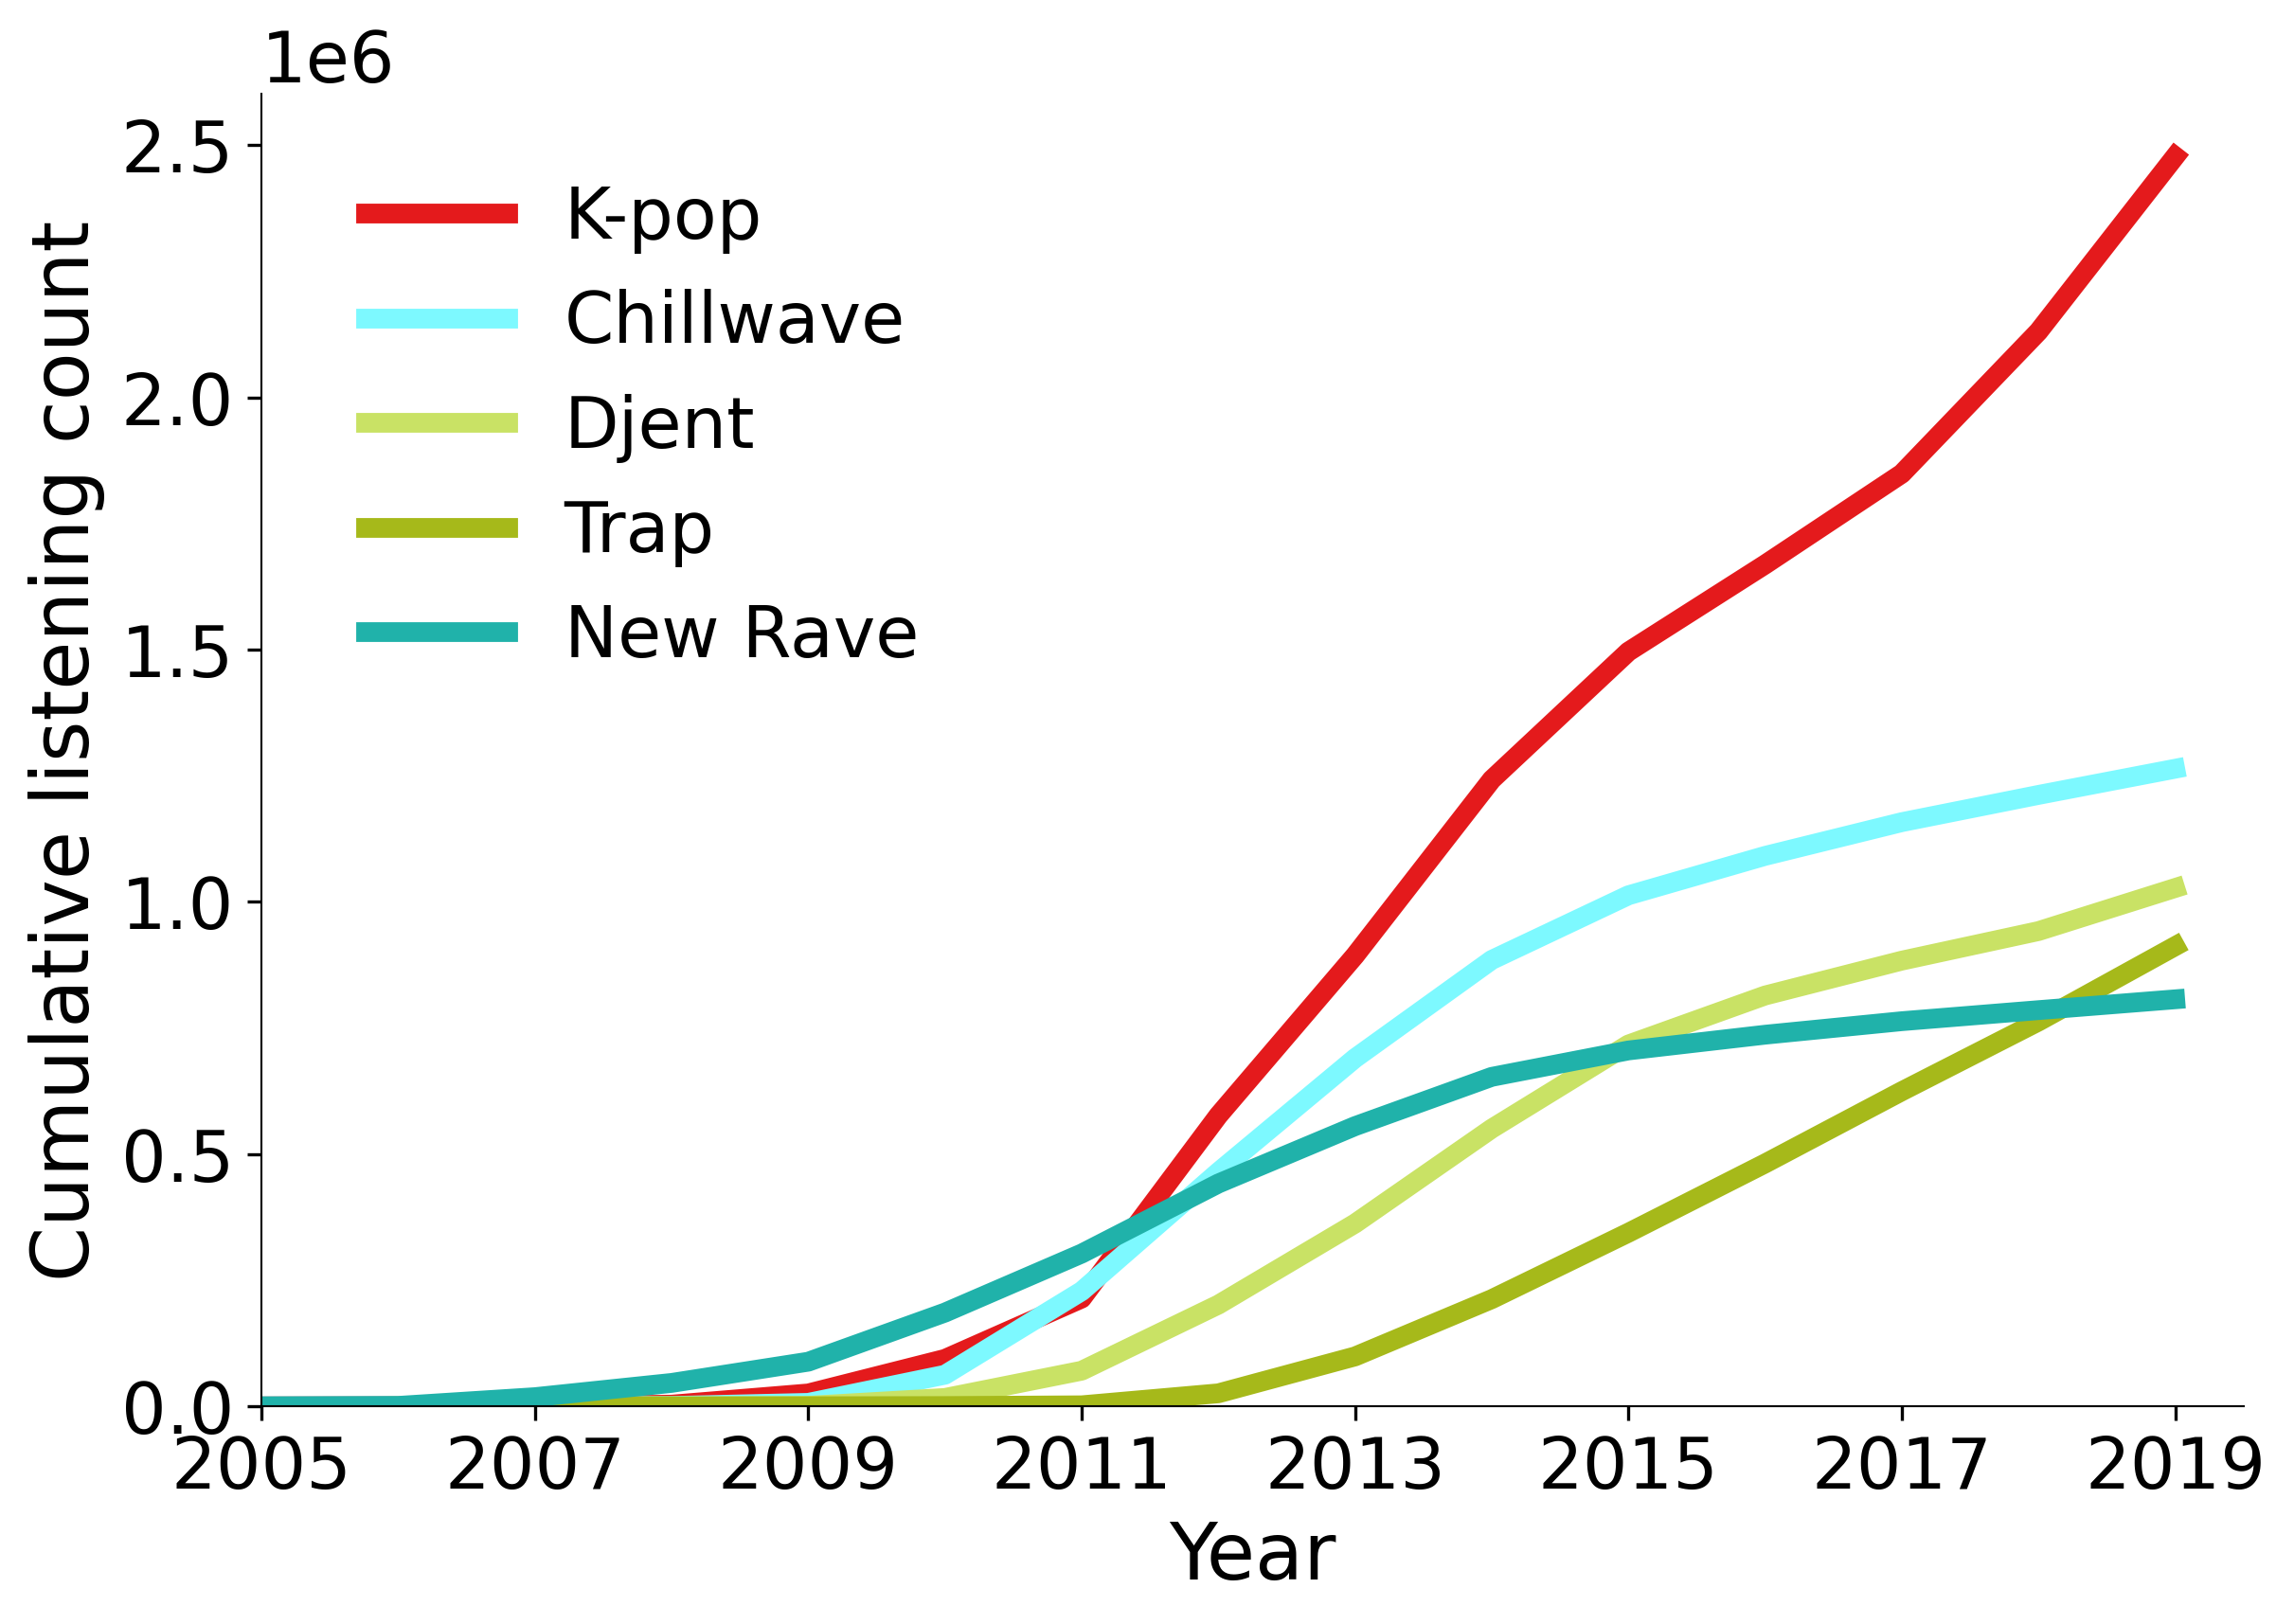

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scienceplots

# ------------------------------------------------------
# 前提:
#  - df_result_top15  ... 上位15ジャンルの一覧を含むDataFrame (カラム: 'top_tag' 等)
#  - df_cumulative     ... "top_tag", "year", "cumulative_listening_count" 等を含むDataFrame
#  - tag_color_map     ... 色指定用の辞書
# ------------------------------------------------------

# ------------------------------------------------------
# データ整形
# ------------------------------------------------------
selected_tags = df_result_top15['top_tag'].unique()
df_cumu_top15 = df_cumulative[df_cumulative['top_tag'].isin(selected_tags)].copy()
df_cumu_top15 = df_cumu_top15[(df_cumu_top15['year'] >= 2005) & (df_cumu_top15['year'] <= 2019)]

df_tag_count = df_cumu_top15.pivot(
    index='year',
    columns='top_tag',
    values='cumulative_listening_count'
).sort_index()

df_tag_count.index = df_tag_count.index.astype(int)

# ------------------------------------------------------
# 凡例の名前変換用の辞書
# ------------------------------------------------------
legend_rename_map = {
    "k-pop": "K-pop",
    "korean_pop": "Korean pop",
    "j-pop": "J-pop",
    "pop": "Pop",
    "rock": "Rock",
    "rap": "Rap",
    "new_rave": "New Rave",
    "chillwave": "Chillwave",
    "trap": "Trap",
    "djent": "Djent",
    "boy band": "Boy band",
    "girl_group": "Girl group",
    "other": "Other",
    "anime": "Anime",
    "visual_kei": "Visual kei",
    "soundtrack": "Soundtrack",
    "j-rock": "J-rock",
    # ... 必要に応じて追加
}

# ------------------------------------------------------
# グラフ描画
# ------------------------------------------------------
plt.rcParams['figure.dpi'] = 300
plt.style.use(['nature'])

fig, ax = plt.subplots(figsize=(9, 6))

for tag in selected_tags:
    if tag not in df_tag_count.columns:
        continue
    
    color = tag_color_map.get(tag, '#888888')  # 定義されていないタグにはグレー
    
    # ↓ 凡例ラベルを legend_rename_map で変換 (無い場合は tag.replace('_',' '))
    renamed_label = legend_rename_map.get(tag.lower(), tag.replace('_', ' '))
    
    ax.plot(
        df_tag_count.index,
        df_tag_count[tag],
        label=renamed_label,
        linewidth=5,
        color=color
    )

# 軸設定
ax.spines[['right', 'top']].set_visible(False)
ax.tick_params(which='both', top=False, right=False, labelsize=18)
ax.yaxis.get_offset_text().set_fontsize(18)
ax.set_xlabel("Year", fontsize=20)
ax.set_ylabel("Cumulative listening count", fontsize=20)
ax.ticklabel_format(style='plain', useOffset=False, axis='x')
ax.set_xticks(range(2005, 2020, 2))  # 2年ごとの目盛りに変更
ax.set_xlim(2005, 2019.5)
ax.set_ylim(bottom=0)  # y軸の下限を0に設定

# 凡例
ax.legend(
    loc='upper left',
    bbox_to_anchor=(0.02, 0.98),  # グラフ内左上の少し内側 (x, y)
    fontsize=18,
    frameon=False
)

# 表示（必要に応じて保存）
#plt.savefig("genre_increase_top5.pdf", dpi=300, bbox_inches='tight')
#plt.savefig("genre_increase_top5.eps", dpi=300, bbox_inches='tight')
plt.show()